In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import process_time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import psutil

# def MAPE2(actual_values, predicted_values):
#     mape = np.mean(np.abs(np.where(np.logical_and(actual_values != 0, predicted_values != 0), (actual_values - predicted_values) / (actual_values + 1e-10), (actual_values - predicted_values) / 100)))
#     return mape

def MAPE(actual_values, predicted_values):
    mape_sum = 0.0
    count = 0

    for actual, predicted in zip(actual_values, predicted_values):
        if actual != 0 and predicted != 0:
            mape_sum += abs((actual - predicted) / actual)
        else:
            mape_sum += abs(actual - predicted) / 100
        count += 1

    if count == 0:
        return 0  # Handle the case when there are no valid entries to avoid division by zero.

    return (mape_sum / count)[0]

In [140]:
df1M = pd.DataFrame(np.loadtxt('./intersect.filter.csv', delimiter=','))
df1M.head() # show the first 5 rows

,0,1,2,3,4
0,-122.0,-37.0,-59.0,-24.0,49019.0
1,-166.0,-62.0,-139.0,-43.0,1040.0
2,99.0,30.0,115.0,68.0,66507.0
3,-159.0,-77.0,-112.0,-62.0,1041.0
4,-63.0,50.0,-3.0,66.0,68350.0


In [141]:
data = np.loadtxt('./intersect.filter.csv', delimiter=',')
Rectangles = data[:,0:4]
Rectangles.shape

(999999, 4)

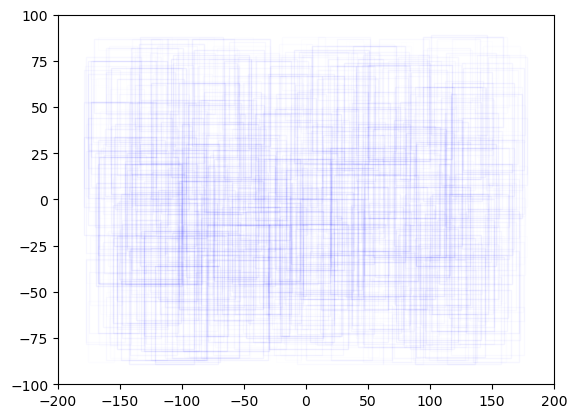

In [142]:
univ_xmin = -180
univ_xmax = 180
univ_ymin = -90
univ_ymax = 90
Surface_univ=(univ_xmax-univ_xmin)*(univ_ymax-univ_ymin)

s=0
rectanglesCoverageRatio = []
for i in Rectangles:
    s = abs((i[3]-i[1])*(i[2]-i[0])/Surface_univ)
    rectanglesCoverageRatio.append(s)
rectanglesCoverageRatio = np.array(rectanglesCoverageRatio)


# Plot 1000 rectangles from x1, y1 to x2, y2
ax = plt.subplot()
for rect, color in zip(Rectangles[0:1000], rectanglesCoverageRatio[0:1000]):
    x1, y1, x2, y2 = rect
    rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='b', facecolor='none', alpha=color)
    ax.add_patch(rectangle)
# The next code show the real rectangles forms with the color of the CoverageRatio
# plt.xlim(min(rect[0] for rect in Rectangles), max(rect[0] for rect in Rectangles))
# plt.ylim(min(rect[1] for rect in Rectangles), max(rect[1] for rect in Rectangles))
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.show()

In [143]:
# Prepare data for the models the input is X and the output is Y
Y = data[:,4:5]
rectanglesCoverageRatio = rectanglesCoverageRatio.reshape(rectanglesCoverageRatio.shape[0],1)
X = data[:,0:4]
# X = np.append(data[:,0:4], rectanglesCoverageRatio, axis=1)


# Split the data into 80% train and 20% test
X_train, X_test_all, y_train, y_test_all = train_test_split(X, Y, test_size=0.2, random_state=3)


# Taking just 100k first data
sample_size = 800000
# X_train = X_train[:sample_size,:]
# y_train = y_train[:sample_size]

Y.shape # (999999, 1)
X.shape # (999999, 5)


# columns = ['x_min','y_min','x_max','y_max','Density']
columns = ['x_min','y_min','x_max','y_max']
Data_Set = pd.DataFrame(data=X,columns=columns)
column = ['number_of_objets']
Target = pd.DataFrame(data=Y,columns=column)

# Split the data into 80% train and 20% test
# X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.2, random_state=3)

# Max, min, mean and median
print("Max :", np.max(Y))
print("Min :", np.min(Y))
print("Mean :", np.mean(Y))
print("Median :", np.median(Y))


Max : 1683002.0
Min : 2.0
Mean : 172835.6677046677
Median : 65194.0


In [144]:
# Random Forest Regressor
print("###### Random Forest Regressor ######")

# Finding best parametres
# t1_start = process_time()
# param_grid = {'n_estimators': [10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
# param_grid = {'n_estimators': [30]}
# randomForestRegressor = RandomForestRegressor(random_state=3)
# gridSearchCV = GridSearchCV(randomForestRegressor, param_grid, cv=5, scoring='neg_median_absolute_error')
# gridSearchCV.fit(X_train, y_train)
# bestEstimatorsNumber = gridSearchCV.best_params_['n_estimators']
# t1_stop = process_time()
# print("Best number of estimators:", bestEstimatorsNumber)
# print("Elapsed time during the GridSearchCV:", t1_stop-t1_start)
bestEstimatorsNumber = 30

# Create the regressor: randomForestRegressor
randomForestRegressor = RandomForestRegressor(n_estimators=bestEstimatorsNumber, random_state=3)

# Fit the regressor to the training data
t1_start = process_time()
randomForestRegressor.fit(X_train, y_train)
t1_stop = process_time()
print("Elapsed time during the learning phase in seconds (",bestEstimatorsNumber," etimators):", t1_stop-t1_start)

# Predict on the test data: y_pred
y_pred = randomForestRegressor.predict(X_test_all)

# Compute and print R^2 and RMSE
print("R^2: {}".format(randomForestRegressor.score(X_test_all, y_test_all)))
# print("Mean Absolute Error: {}".format(MAE(y_test, y_pred)))
# print(f"Mean Absolute Percentage Error: {MAPE(y_test, y_pred):.2%}")
print(f"Mean Absolute Error of 20% of all: {MAE(y_test_all, randomForestRegressor.predict(X_test_all)):.2f}")
print(f"Mean Absolute Percentage Error of 20% of all: {MAPE(y_test_all, randomForestRegressor.predict(X_test_all)):.2%}")

import pickle
filename = f'./LearnedModels/RF/RF_withoutCoverageRatio_{sample_size}_{(t1_stop-t1_start):.2f}s_{MAPE(y_test_all, randomForestRegressor.predict(X_test_all)):.2%}_{MAE(y_test_all, randomForestRegressor.predict(X_test_all)):.2f}.sav'
pickle.dump(randomForestRegressor, open(filename, 'wb'))

# Time to predict calculated 10 times and the average is calculated
total_duration = 0
total_read = 0
total_write = 0
for i in range(10):
    io_before = psutil.disk_io_counters()
    t1_start = process_time()
    y_pred_tmp = randomForestRegressor.predict(X_test_all)
    t1_stop = process_time()
    io_after = psutil.disk_io_counters()
    total_duration += (t1_stop-t1_start)
    total_read += io_after.read_count - io_before.read_count
    total_write += io_after.write_count - io_before.write_count

print(f"I/O Operations (mean of 10 times) - Reads: {total_read/10/len(y_pred_tmp)}, Writes: {total_write/10/len(y_pred_tmp)}")
print("Elapsed time during one estimation in seconds (mean of 10 times):", (total_duration/10)/len(y_pred_tmp))
print("Elapsed time during one estimation in microseconds (mean of 10 times):", (total_duration/10)/len(y_pred_tmp)*1000000)

###### Random Forest Regressor ######


/home/nadir/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Elapsed time during the learning phase in seconds ( 30  etimators): 98.76383421599985
R^2: 0.9994480920929664
Mean Absolute Error of 20% of all: 2552.67
Mean Absolute Percentage Error of 20% of all: 2.20%
I/O Operations (mean of 10 times) - Reads: 3.5e-06, Writes: 0.000451
Elapsed time during one estimation in seconds (mean of 10 times): 2.2582893289000595e-05
Elapsed time during one estimation in microseconds (mean of 10 times): 22.582893289000594


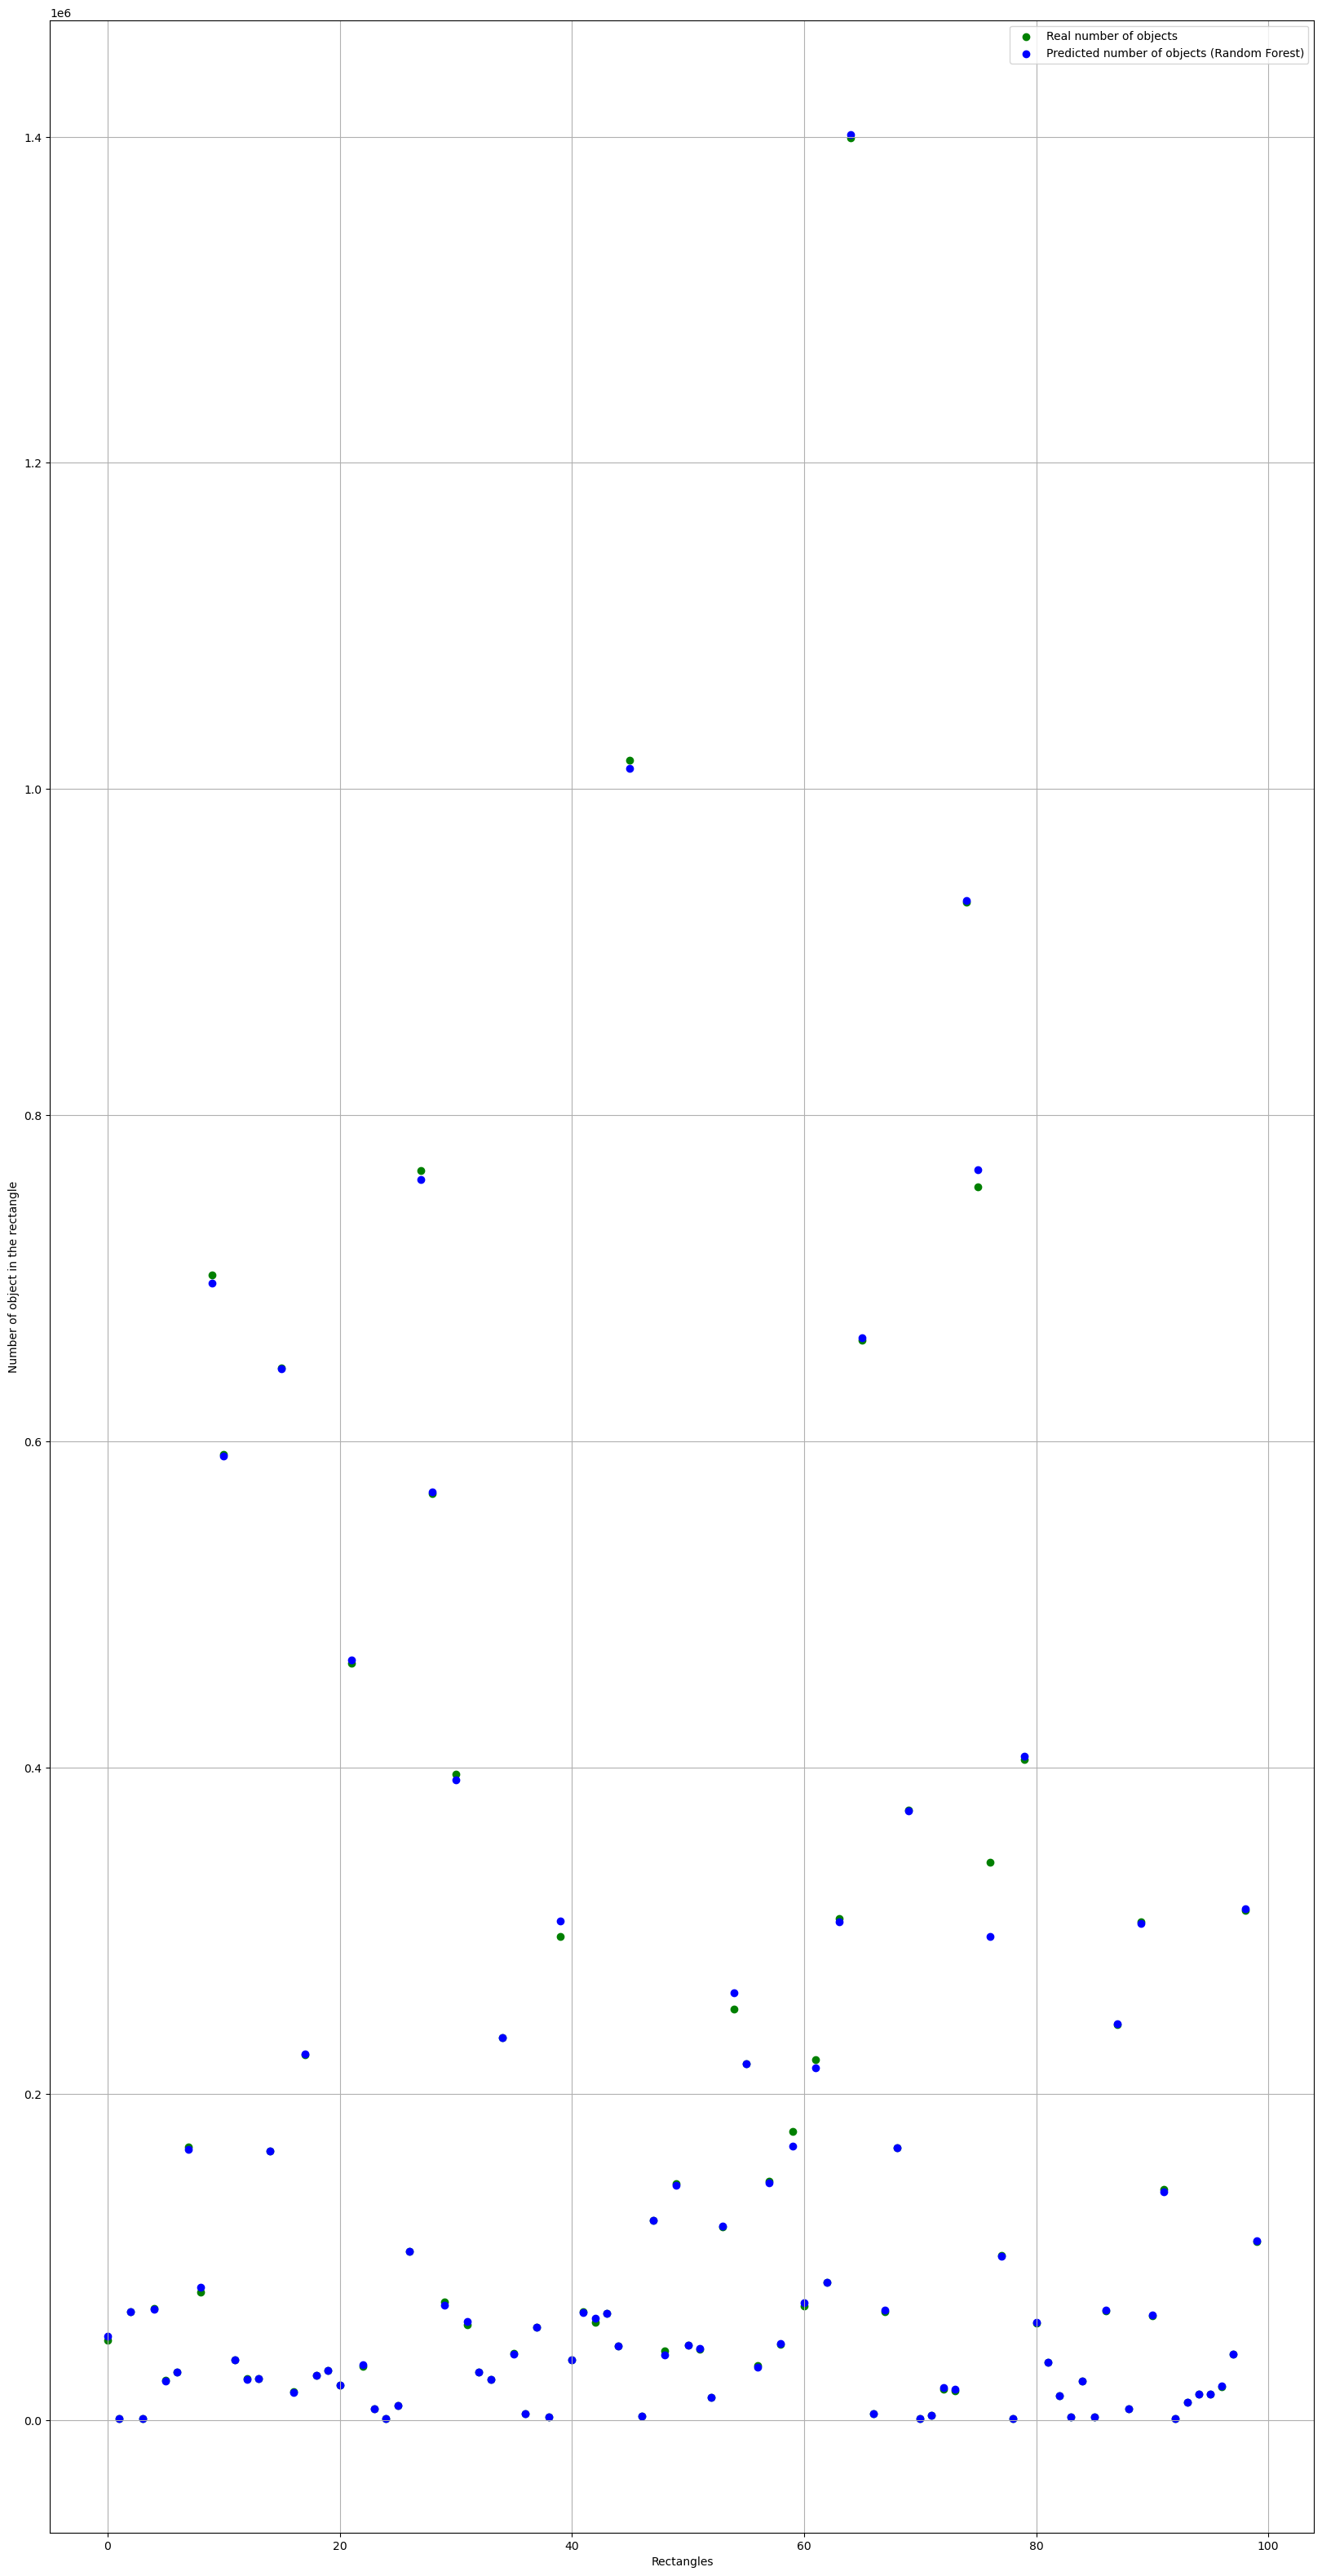

,Real number of objects,Predicted number of objects (Random Forest)
0,49019.0,5.143310e+04
1,1040.0,1.040000e+03
2,66507.0,6.662913e+04
3,1041.0,1.040933e+03
4,68350.0,6.786710e+04
5,24214.0,2.391233e+04
6,29535.0,2.928080e+04
7,167357.0,1.658615e+05
8,78617.0,8.119010e+04
9,702271.0,6.969141e+05


In [145]:
# Compare the predicted number of objects with the real number of objects

# Create a scatter plot for the real number of objects
Y[:100]

# Create a scatter plot for the predicted number of objects by Decision Tree compared to the real number of objects
plt.figure(figsize=(20, 40))
plt.scatter(range(100), Y[:100], c='green', label='Real number of objects')
plt.scatter(range(100), randomForestRegressor.predict(X[:100]), c='blue', label='Predicted number of objects (Random Forest)')
plt.xlabel('Rectangles')
plt.ylabel('Number of object in the rectangle')
plt.legend()
plt.grid()
plt.show()

# Show the same plot data in a table
real_values = Y[:100].ravel()
predicted_RF_values = randomForestRegressor.predict(X[:100]).ravel()
df = pd.DataFrame({'Real number of objects': real_values, 'Predicted number of objects (Random Forest)': predicted_RF_values})
# Print the table with all lines
pd.set_option("display.max_rows", None, "display.max_columns", None)
df

Median : 65194.0
Minimal number of objects: 0, Mean absolute error of Random Forest: 2552.6685684999998, Mean absolute percentage error of Random Forest: 2.20%
Minimal number of objects: 10, Mean absolute error of Random Forest: 2553.0383873995065, Mean absolute percentage error of Random Forest: 2.19%
Minimal number of objects: 100, Mean absolute error of Random Forest: 2555.103250771153, Mean absolute percentage error of Random Forest: 2.18%
Minimal number of objects: 1000, Mean absolute error of Random Forest: 2602.6245016162425, Mean absolute percentage error of Random Forest: 2.15%
Minimal number of objects: 5000, Mean absolute error of Random Forest: 2858.8391940321435, Mean absolute percentage error of Random Forest: 1.90%
Minimal number of objects: 40027, Mean absolute error of Random Forest: 4075.7647372807423, Mean absolute percentage error of Random Forest: 1.88%
Minimal number of objects: 100000, Mean absolute error of Random Forest: 5177.717108515523, Mean absolute percent

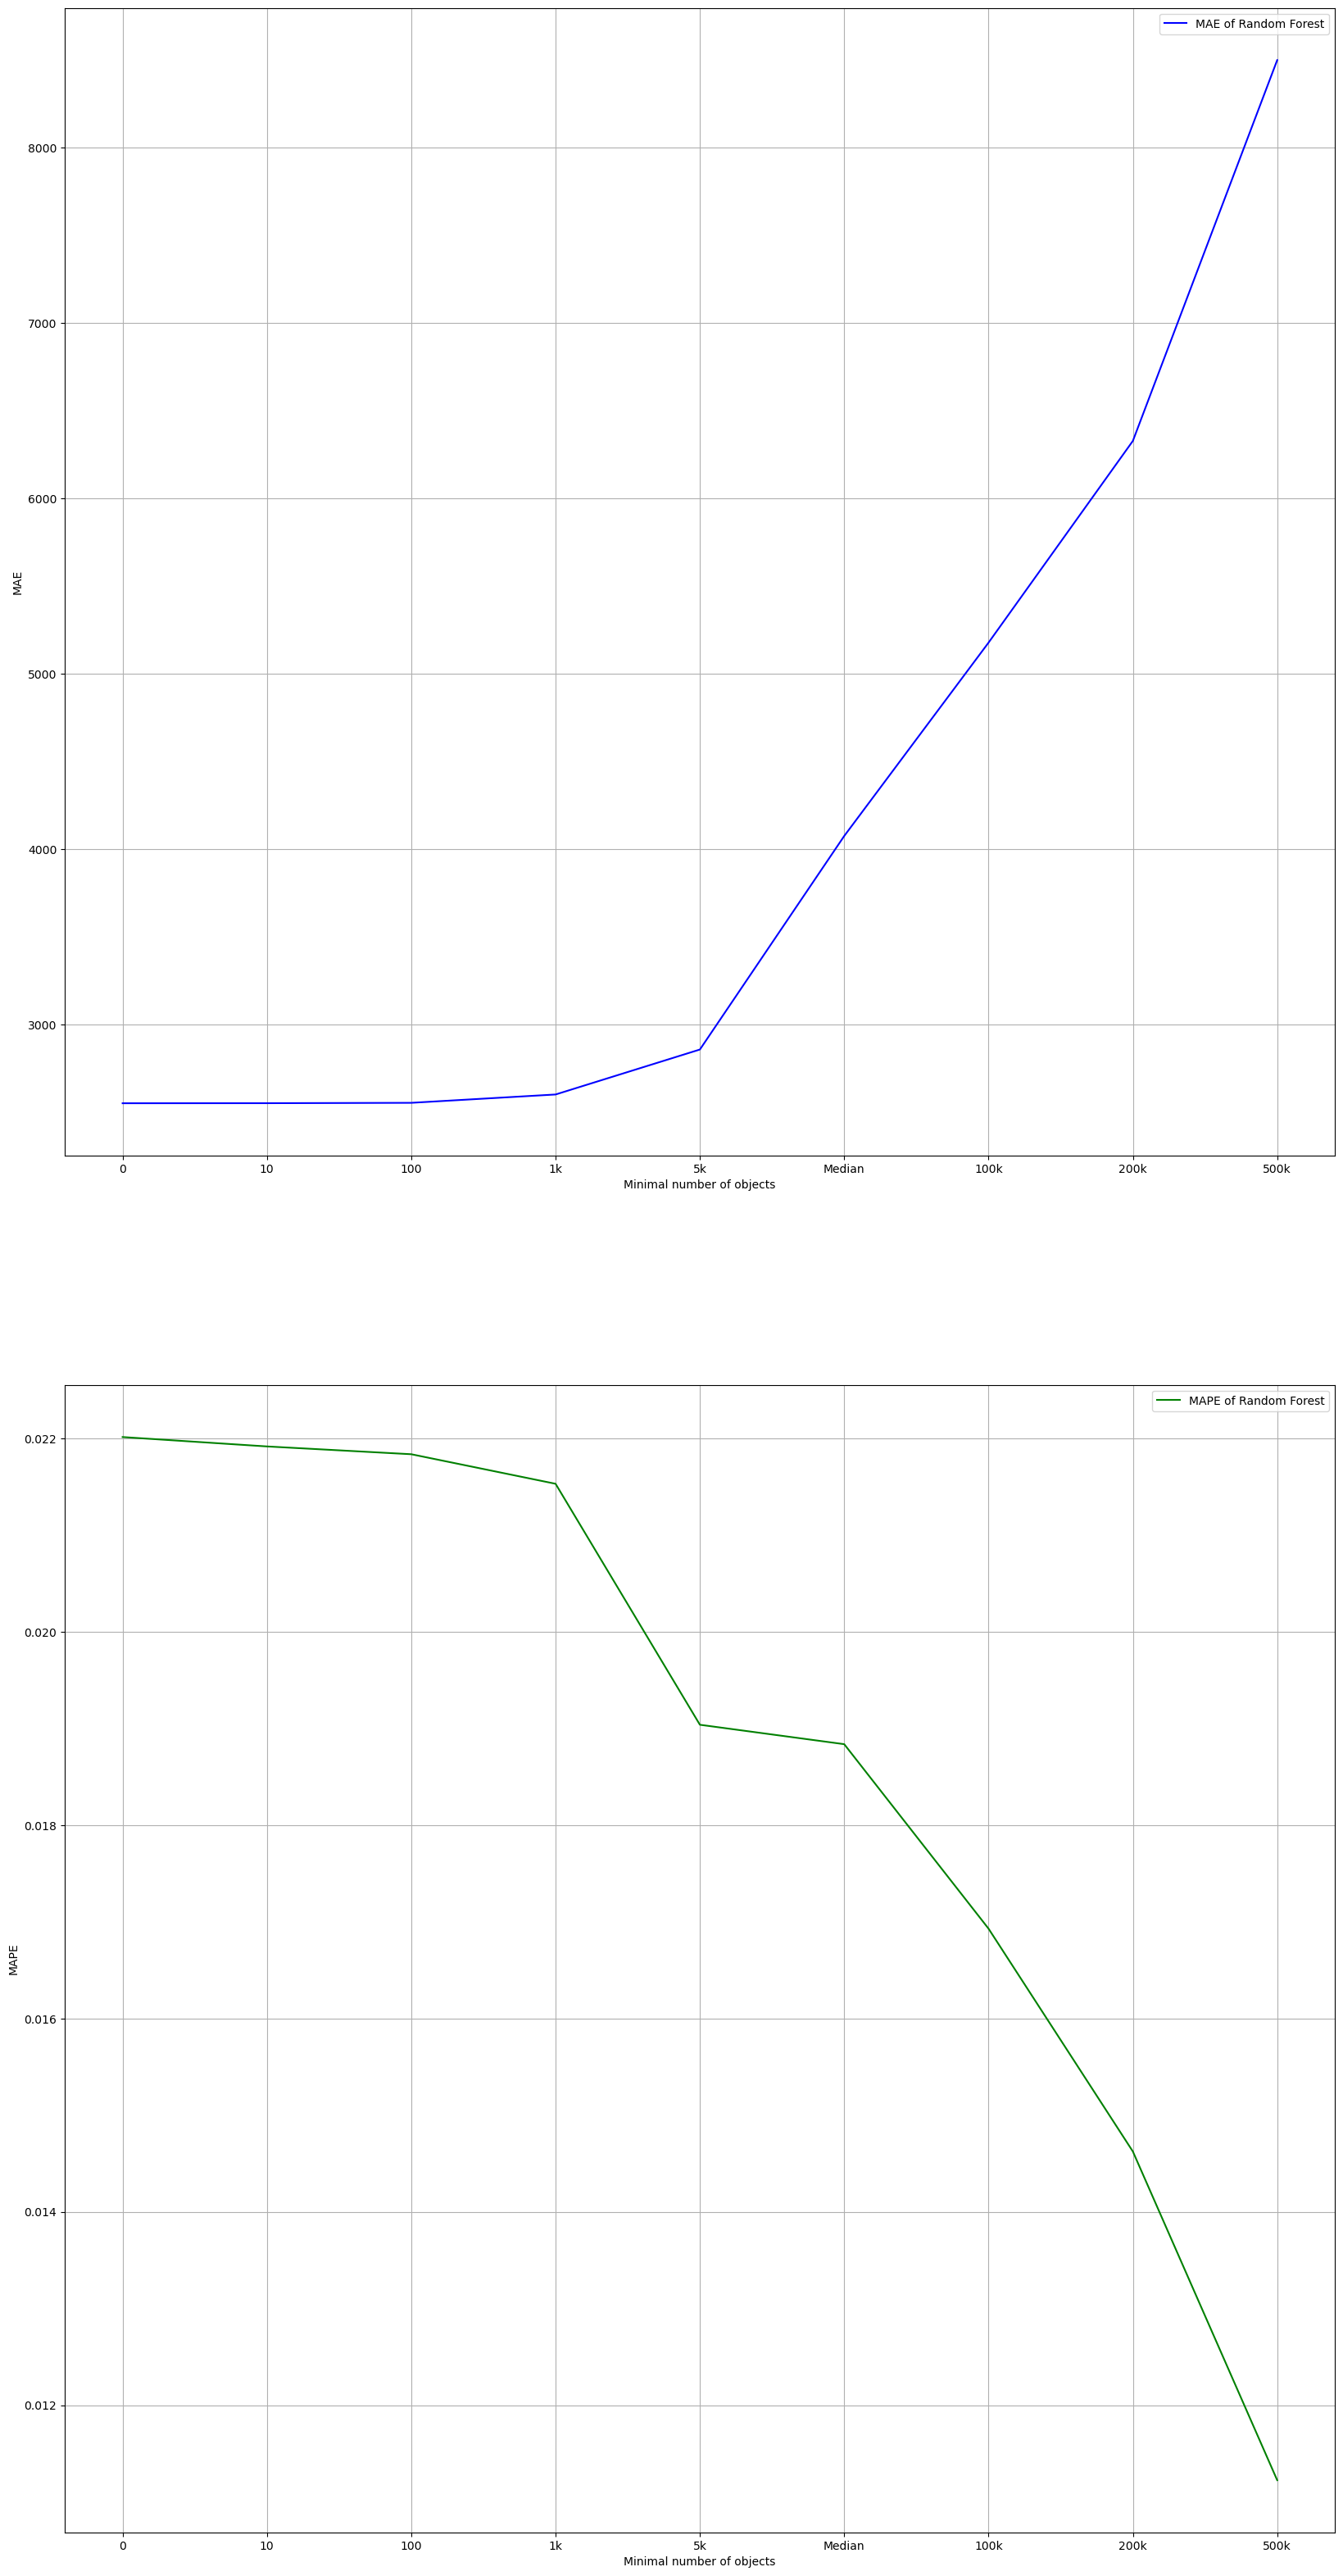

In [146]:
# Select test data just who have number of objects > median
median = np.median(Y)
print("Median :", median)
y_median = y_test_all
X_median = X_test_all


# Create a graph changing the minimal number of objects and display the MAE and MAPE for each minimal number of objects
# minimal_number_of_objects = 10 # 10, 100, 1000, 10000, 100000
maeRF = []
mapeRF = []
minimal_number_of_objects_range = [0, 10, 100, 1000, 5000, 40027, 100000, 200000, 500000]
for i in minimal_number_of_objects_range:
    minimal_number_of_objects = i
    merged_X_y = np.append(X_median, y_median, axis=1)
    merged_X_y = merged_X_y[merged_X_y[:, 4] >= minimal_number_of_objects]
    X_median = merged_X_y[:, 0:4]
    y_median = merged_X_y[:, 4:5]
    maeRF.append(MAE(y_median, randomForestRegressor.predict(X_median)))
    mapeRF.append(MAPE(y_median, randomForestRegressor.predict(X_median)))
    print(f"Minimal number of objects: {minimal_number_of_objects}, Mean absolute error of Random Forest: {maeRF[-1]}, Mean absolute percentage error of Random Forest: {mapeRF[-1]:.2%}")

minimal_number_of_objects_range_str = ['0', '10', '100', '1k', '5k', 'Median', '100k', '200k', '500k',]
plt.figure(figsize=(20, 40))
plt.subplot(2, 1, 1)
plt.plot(minimal_number_of_objects_range_str, maeRF, c='blue', label='MAE of Random Forest')
plt.xlabel('Minimal number of objects')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(minimal_number_of_objects_range_str, mapeRF, c='green', label='MAPE of Random Forest')
plt.xlabel('Minimal number of objects')
plt.ylabel('MAPE')
plt.legend()
plt.grid()
plt.show()
